# Análisis de sentimientos de películas. 
Se tiene comentarios de películas
en español, que serán clasificadas en las categorías de positivo, negativo. 

# 1. Instalación e importación de librerías.

In [33]:
!pip install inflect
!pip install pandas-profiling==2.7.1

In [66]:
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

import string


import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import nltk
import nltk.data
import spacy
# Punkt permite separar un texto en frases.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fesar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fesar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fesar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Perfilamiento y entendimiento de los datos

In [35]:
 # Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('data/MovieReviews.csv', sep=',', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data_t=data

In [36]:
textos = data_t.copy()
textos['Conteo'] = [len(x) for x in textos['review_es']]
textos['Moda'] = [max(set(x), key=x.count) for x in textos['review_es']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['review_es']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['review_es']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
#ProfileReport(textos)

# 3. Preparación de datos

Para poder realizar el pre-procesamiento de los datos, se pasará por tres etapas:
- Limpieza de los datos.
- Tokenización.
- Normalización.

### 3.1 Limpieza de los datos

In [37]:
# Eliminar primera columna sin nombre que es el id
data_t = data_t.drop(data_t.columns[0], axis=1)
data_t.head()

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,positivo
1,Supongo que algunos directores de películas de...,positivo
2,Es difícil contarle más sobre esta película si...,positivo
3,"La película comienza muy lentamente, con el es...",positivo
4,Esta película es verdadera acción en su máxima...,positivo


In [41]:
stop_words = set(stopwords.words('spanish'))
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.encode('utf-8', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub(r'\d+', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### 3.2 Tokenización

In [39]:
data_t.head()

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,positivo
1,Supongo que algunos directores de películas de...,positivo
2,Es difícil contarle más sobre esta película si...,positivo
3,"La película comienza muy lentamente, con el es...",positivo
4,Esta película es verdadera acción en su máxima...,positivo


In [43]:
data_t['review_es'] = data_t['review_es'].apply(contractions.fix) #Aplica la corrección de las contracciones  
data_t['words'] = data_t['review_es'].apply(word_tokenize)
data_t['words'] = data_t['words'].apply(preprocessing)
data_t.head()

,review_es,sentimiento,words
0,Si está buscando una película de guerra típica...,positivo,"[si, buscando, película, guerra, típica, así, ..."
1,Supongo que algunos directores de películas de...,positivo,"[supongo, directores, películas, lujo, sentado..."
2,Es difícil contarle más sobre esta película si...,positivo,"[difícil, contarle, película, estropearlalo, d..."
3,"La película comienza muy lentamente, con el es...",positivo,"[película, comienza, lentamente, estilo, vida,..."
4,Esta película es verdadera acción en su máxima...,positivo,"[película, verdadera, acción, máxima, expresió..."


###  3.3. Normalización

In [44]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

data_t['words'] = data_t['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
data_t.head()

,review_es,sentimiento,words
0,Si está buscando una película de guerra típica...,positivo,"[si, buscando, películ, guerr, típica, así, no..."
1,Supongo que algunos directores de películas de...,positivo,"[supongo, direct, película, lujo, sentado, bus..."
2,Es difícil contarle más sobre esta película si...,positivo,"[difícil, contarl, películ, estropearlalo, dis..."
3,"La película comienza muy lentamente, con el es...",positivo,"[películ, comienz, lenta, estilo, vid, wallac,..."
4,Esta película es verdadera acción en su máxima...,positivo,"[películ, verdader, acción, máxima, expresión,..."


###  3.4 Selección de campos

In [45]:
data_t['words'] = data_t['words'].apply(lambda x: ' '.join(map(str, x)))
data_t

,review_es,sentimiento,words
0,Si está buscando una película de guerra típica...,positivo,si buscando películ guerr típica así not afici...
1,Supongo que algunos directores de películas de...,positivo,supongo direct película lujo sentado buscando ...
2,Es difícil contarle más sobre esta película si...,positivo,difícil contarl películ estropearlalo disfruté...
3,"La película comienza muy lentamente, con el es...",positivo,películ comienz lenta estilo vid wallac napalm...
4,Esta película es verdadera acción en su máxima...,positivo,películ verdader acción máxima expresión mej e...
...,...,...,...
4995,"""Criminal decente ordinario"" es triste porque ...",negativo,crimin dec ordinario trist obvia tratando triu...
4996,Savage Island (2003) es una película coja.Es m...,negativo,sav island películ coja video video cas ilumin...
4997,Quien escribió el script para esta película no...,negativo,escribió script películ merec trabaj hollywood...
4998,in a TV-movie 70's kind of way It is one of th...,negativo,in tvmovie s kind of way it is on of thos movy...


In [46]:
X_data, y_data = data_t['words'],data_t['sentimiento']
y_data = (y_data == 'positivo').astype(int)
y_data

0       1
1       1
2       1
3       1
4       1
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: sentimiento, Length: 5000, dtype: int32

In [47]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_data)
print(X_dummy.shape)
X_dummy.toarray()[0]

(5000, 90534)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [48]:
count = CountVectorizer()
X_count = count.fit_transform(X_data)
print(X_count.shape)
X_count.toarray()[0]

(5000, 90534)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [49]:
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(X_data)

print(X_tf_idf.shape)
X_tf_idf.toarray()[0]

(5000, 90534)


array([0., 0., 0., ..., 0., 0., 0.])

# 4. Creación y Aplicación del modelo

In [50]:
stop_words = set(stopwords.words('spanish'))

In [51]:
data_t['sentimiento'].value_counts(dropna = False, normalize = True)

positivo    0.5
negativo    0.5
Name: sentimiento, dtype: float64

In [52]:
# El parámetro 'stratify' es útil para asegurar que ambos conjuntos de datos queden aproximadamente balanceados
# Cuando se cuenta con muy pocos datos etiquetados, por lo general se debe disponer de una menor cantidad de datos para evaluación
# X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify = y_data, random_state = 1)

In [53]:
X_train.shape

(4000,)

In [54]:
pd.Series(y_train).value_counts(normalize = True)

0    0.5
1    0.5
Name: sentimiento, dtype: float64

### 4.1 Entrenando y evaluando un modelo usado BoW

In [56]:
X_bow = count.fit_transform(X_train)

In [57]:
len(count.vocabulary_)

79097

In [59]:
bow_model = RandomForestClassifier(random_state = 2)

In [60]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<AxesSubplot:>

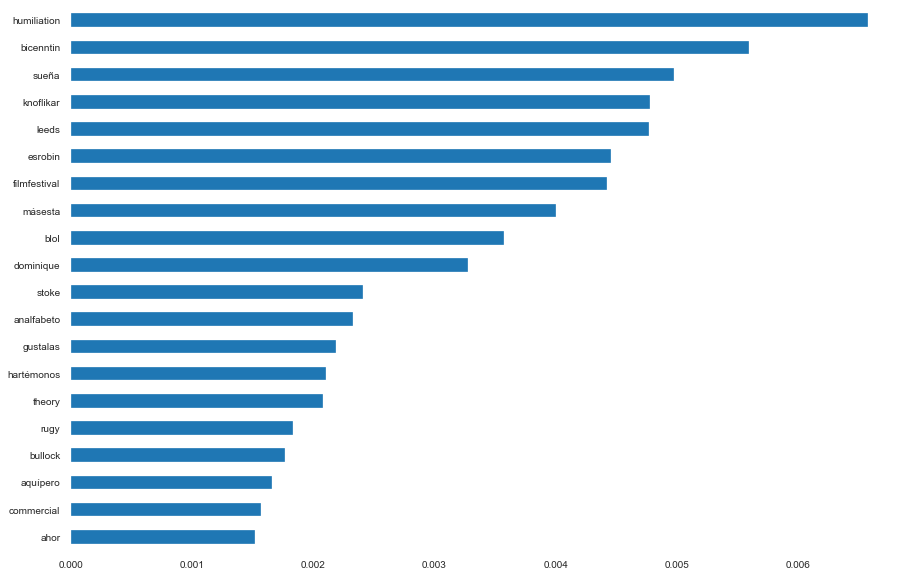

In [62]:
# La 'feature importance' en modelos basados en árboles de decisión indican cuales son las características más importantes al momento de tomar una decisión
pd.Series(bow_model.feature_importances_, index = count.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [63]:
bow_estimators = bow_model.estimators_
print('Number of trees:', len(bow_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 180.21


In [64]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(count.transform(X_test))

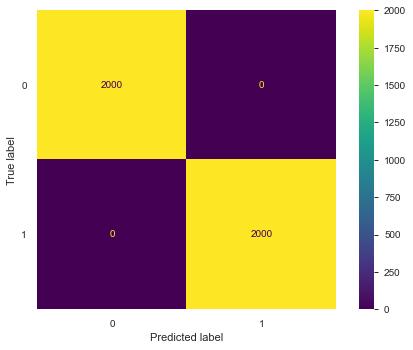

In [67]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

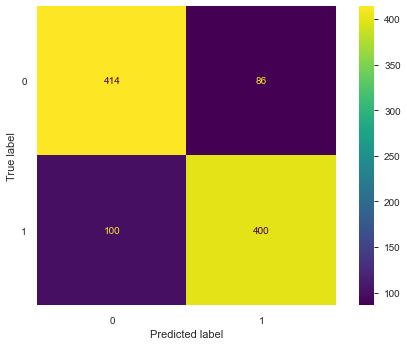

In [68]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [70]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_bow_predict, pos_label = 1))
    print('Recall:', recall_score(y_train, y_train_bow_predict, pos_label = 1))
    print('F1:', f1_score(y_train, y_train_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_bow_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_bow_predict, average = None))
    print('F1:', f1_score(y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [71]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 1))
    print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 1))
    print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
    print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: 0.823045267489712
Recall: 0.8
F1: 0.8113590263691685
